In [1]:
import numpy as np
import cv2
import pandas as pd
from scipy import ndimage as nd
 
import pickle
from matplotlib import pyplot as plt
import os
from skimage.io import imread, imshow
from skimage.filters import roberts, sobel, scharr, prewitt
import glob

In [3]:
source_paths1 = "S1Hand/"
source_paths2 = "S2Hand"
label_path = "LabelHand/"

sources1 = []
sources2 =[]
label = []

for file in os.listdir(source_paths1):
    if file.endswith("tif"):
      sources1.append(file)

for file in os.listdir(source_paths2):
    if file.endswith("tif"):
      sources2.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)


## Sanity Check
sources1 = sorted(sources1)
sources2 = sorted(sources2)
label = sorted(label)
print(len(sources1))
print(len(sources2))
print(len(label))

577
577
577


In [4]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES  - Sentinel 1
################################################################
image_dataset_s1 = pd.DataFrame()  #Dataframe to capture image features

img_path = "S1Hand/" ## CHANGE ME!!!
for image in sources1:
  df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
  img = imread(img_path+image)

  vv = imread(img_path + image)[0:1,:,:].reshape((128,128)) 
  vh = imread(img_path + image)[1:2:,:,:].reshape((128,128))
  vv_vh = (vv/vh)
 
  #Add pixel values to the data frame
  vv_values = vv.reshape(-1)
  df['VV'] = vv_values   #Pixel value itself as a feature
            
  vh_values = vh.reshape(-1)
  df['VH'] = vh_values   
  # df['Image_Names1']=image          
  vv_vh_values = vv_vh.reshape(-1)
  df['VV/VH'] = vv_vh_values   

  #MEDIAN with sigma=3
  median_img = nd.median_filter(vh, size=3)
  median_img1 = median_img.reshape(-1)
  df['Median_s3'] = median_img1

  #VARIANCE with size=3
  variance_img = nd.generic_filter(vh, np.var, size=3)
  variance_img1 = variance_img.reshape(-1)
  df['Variance_s3'] = variance_img1  

  #ROBERTS EDGE
  edge_roberts = roberts(vh)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  ######################################                    
  #Update dataframe for images to include details for each image in the loop
  image_dataset_s1 = image_dataset_s1.append(df)

In [5]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES - Sentinel 2
################################################################
image_dataset_s2 = pd.DataFrame()  #Dataframe to capture image features

img_path = "S2Hand/" # CHANGE ME!!!
for image in sources2: #os.listdir(img_path):
    print(image)
    df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
    #Reset dataframe to blank after each loop.

    blue = imread(img_path + image)[0:1,:,:].reshape((128,128))    
    green = imread(img_path + image)[1:2,:,:].reshape((128,128))
    red = imread(img_path + image)[2:3,:,:].reshape((128,128))
    nir = imread(img_path + image)[3:4,:,:].reshape((128,128))
    swir = imread(img_path + image)[4:5,:,:].reshape((128,128))

    # df["Image_Name"] = image    
    # Sentinel-2 MNDWI = (B03 - B08) / (B03 + B08)
    ndwi = (green - swir)/ (green + swir)
    ndwi_values = ndwi.reshape(-1)
    df['NDWI'] = ndwi_values  

    # Sentinel 2 NDVI = (NIR - RED) / (NIR + RED), where RED is B4 and NIR is B8
    ndvi = (nir - red)/ (red + nir)
    ndvi_values = ndvi.reshape(-1)
    df['NDVI'] = ndvi_values 

    #MEDIAN with sigma=3
    median_img = nd.median_filter(nir, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median_s3'] = median_img1

   #VARIANCE with size=3
    variance_img = nd.generic_filter(nir, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance_s3'] = variance_img1  

   #ROBERTS EDGE
    edge_roberts = roberts(nir)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

  #START ADDING DATA TO THE DATAFRAME  

    blue_values = blue.reshape(-1)
    df['Blue'] = blue_values  
            
    green_values = green.reshape(-1)
    df['Green'] = green_values   
             
        
    image_dataset_s2 = image_dataset_s2.append(df)  

Bolivia_103757_S2Hand_384256384512.tif
Bolivia_129334_S2Hand_00128128.tif
Bolivia_129334_S2Hand_0256384128.tif
Bolivia_129334_S2Hand_128384512256.tif
Bolivia_129334_S2Hand_256256384384.tif
Bolivia_129334_S2Hand_256384512384.tif
Bolivia_23014_S2Hand_0384512128.tif
Bolivia_242570_S2Hand_00128128.tif
Bolivia_242570_S2Hand_0256384128.tif
Bolivia_242570_S2Hand_1280128256.tif
Bolivia_242570_S2Hand_128256384256.tif
Bolivia_242570_S2Hand_2560128384.tif
Bolivia_242570_S2Hand_256128256384.tif
Bolivia_242570_S2Hand_3840128512.tif
Bolivia_290290_S2Hand_0256384128.tif
Bolivia_290290_S2Hand_0384512128.tif
Bolivia_314919_S2Hand_00128128.tif
Bolivia_314919_S2Hand_0256384128.tif
Bolivia_314919_S2Hand_3840128512.tif
Bolivia_314919_S2Hand_384128256512.tif
Bolivia_432776_S2Hand_00128128.tif
Bolivia_432776_S2Hand_0128256128.tif
Bolivia_432776_S2Hand_128128256256.tif
Bolivia_432776_S2Hand_128384512256.tif
Ghana_1033830_S2Hand_128128256256.tif
Ghana_141910_S2Hand_128128256256.tif
Ghana_141910_S2Hand_12825638

In [6]:
###########################################################
# STEP 2: READ LABELED IMAGES (MASKS) AND CREATE ANOTHER DATAFRAME
    # WITH LABEL VALUES AND LABEL FILE NAMES
##########################################################
mask_dataset = pd.DataFrame()  #Create dataframe to capture mask info.
# label_path = "/content/S1Label" #iterate through each file to perform some action

mask_path = "LabelHand/" ### CHANGE ME!!!
for mask in label:   #os.listdir(mask_path):
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = imread(mask_path + mask)
    label = input_mask
    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    mask_dataset = mask_dataset.append(df2)  #Update mask dataframe with all the info from each mask

In [7]:
###########################################################
# CONCATENATE S2 AND S1 DATAFRAMES
##########################################################
frames = [image_dataset_s1, image_dataset_s2]

image_dataset = pd.concat(frames,axis=1,join='outer')

In [8]:
################################################################
 #  STEP 3: GET DATA READY FOR RANDOM FOREST (or other classifier)
 # COMBINE BOTH DATAFRAMES INTO A SINGLE DATASET
###############################################################
dataset = pd.concat([image_dataset, mask_dataset], axis=1)    #Concatenate both image and mask datasets

#If you expect image and mask names to be the same this is where we can perform sanity check
#dataset['Image_Name'].equals(dataset['Mask_Name'])   
##
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
# dataset.fillna(-1, inplace=True)
dataset.fillna(999, inplace=True)
# dataset = dataset[dataset.Label_Value != -1]
dataset.dropna()
# dataset = dataset.reset_index()


#Assign training features to X and labels to Y
#Drop columns that are not relevant for training (non-features)
X = dataset.drop(labels = ["Mask_Name","Label_Value"], axis=1) 

#Assign label values to Y (our prediction)
Y = dataset["Label_Value"].values 

In [9]:
## Sanity Check
print(X.shape)
print(Y.shape)

(9453568, 13)
(9453568,)


In [10]:
################################################################
 #  STEP : Scale The Features
###############################################################
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [11]:
##Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3) #random_state=20

In [12]:
####################################################################
# STEP 4: Define the classifier and fit a model with our training data
###################################################################

#Import training classifier
from sklearn.ensemble import RandomForestClassifier
## Instantiate model with n number of decision trees
model = RandomForestClassifier(n_estimators = 20, verbose=10)

## Train the model on training data
model.fit(X_scaled, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s


building tree 4 of 20


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.5min remaining:    0.0s


building tree 5 of 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.0min remaining:    0.0s


building tree 6 of 20


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.6min remaining:    0.0s


building tree 7 of 20


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.1min remaining:    0.0s


building tree 8 of 20


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.8min remaining:    0.0s


building tree 9 of 20


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.3min remaining:    0.0s


building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 30.9min finished


RandomForestClassifier(n_estimators=20, verbose=10)

In [13]:
#######################################################
# STEP 5: Accuracy check
#########################################################

from sklearn import metrics
prediction_test = model.predict(X_scaled)
##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(Y, prediction_test))
print("IOU = ", metrics.jaccard_score(Y, prediction_test, average='micro'))
print("Precision = ", metrics.precision_score(Y, prediction_test,average='micro'))
print("Recall = ", 	metrics.recall_score(Y, prediction_test,average='micro'))
print("F1 score = ", metrics.f1_score(Y, prediction_test,average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


Accuracy =  0.9988055303563691
IOU =  0.9976139108238262
Precision =  0.9988055303563691
Recall =  0.9988055303563691
F1 score =  0.9988055303563691


Text(0.5, 0, 'Random Forest Feature Importance')

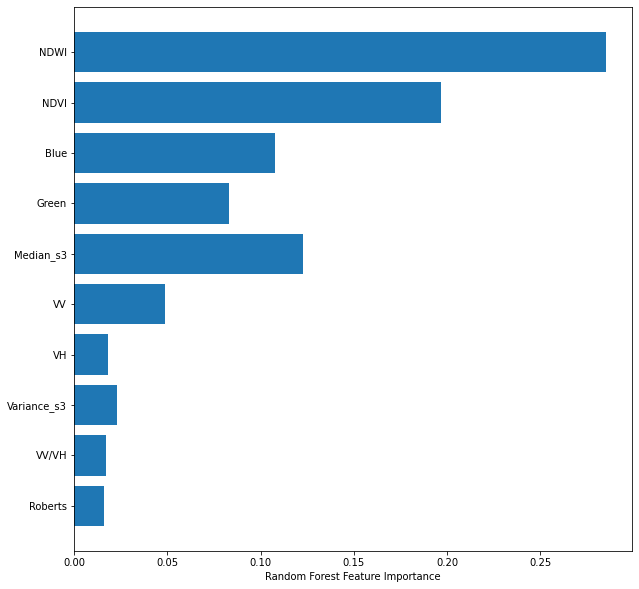

In [14]:
### Feature Importance ####
# model.feature_importances_

# plt.barh(image_dataset.columns, model.feature_importances_)
fig=plt.figure(figsize=(10,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.margins(x=0, y=-0.10) 
plt.xlabel("Random Forest Feature Importance")

In [ ]:
##########################################################
#STEP 6: SAVE MODEL FOR FUTURE USE
###########################################################
##You can store the model for future use. In fact, this is how you do machine elarning
##Train on training images, validate on test images and deploy the model on unknown images. 
#
#
##Save the trained model as pickle string to disk for future use
model_name = "RF_S1Hand"
pickle.dump(model, open(model_name, 'wb'))
#
##To test the model on future datasets
#loaded_model = pickle.load(open(model_name, 'rb'))